In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import *
from collections import Counter
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
dzip = lambda *args: dict(zip(*args))

def name_node(n):
    name = ''
    while True:
        n -= 1;
        name = chr(ord('A') + n%26) + name;
        n = n // 26
        if n < 0:
            break
        
    return name[1:]

# Graph Helper Functions

In [5]:
from operator import itemgetter
from networkx import community

def weights(G):
    return {(u,v):d['weights'] for u,v,d in G.edges(data=True)}

def lightest_edge(G):
    u, v, w = min(G.edges(data='weights'), key=itemgetter(2))
    return (u, v)

def heaviest_edge(G):
    u, v, w = max(G.edges(data='weights'), key=itemgetter(2))
    return (u, v)

def median_edge(G):
    u, v, w = sorted(G.edges(data='weights'), key=itemgetter(2))[len(G.edges)//2]
    return (u, v)

def draw_graph(G, pos, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    nx.draw(G, pos=pos, with_labels=True, ax=ax)
    #nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=weights(G));  

# Instant Insanity Helper Functions

In [6]:

def generate_graph_ii(puzzle):
    G = nx.Graph()    
    # create nodes
    node_list = list(puzzle.keys())
    G.add_nodes_from(node_list)
    
    # create edge if the nodes share colors
    append = lambda a,b: a.append(b)
    a = dict(starmap(lambda a,b: (node_list[a], dict(Counter(chain(*b)))), enumerate(puzzle.values())))
    for b, data in pd.DataFrame(a).T.iteritems():
        nodes = data.iloc[np.where(~data.isna())].index.to_list()
        edges = [edge for edge in product(nodes, nodes) if edge[0] < edge[1]]
        weights = [data.iloc[np.where(data.index.isin((a, b)))].sum() for a, b in edges]
        G.add_edges_from(edges, weights=sum(weights))
        
    return G

def puzzle_from_seed_ii(seed, n):
    group = lambda l, n: (tuple(l[j:j+n]) for j in range(0, len(l), n))
    generate_colors = lambda i: int(1+(np.floor(i*seed)%n))
    colors = group(list(group(list(map(generate_colors, range(1, 6*n+1))), 2)), 3)
    cubes = map(name_node, range(1, n+1))
    return dzip(cubes, colors)

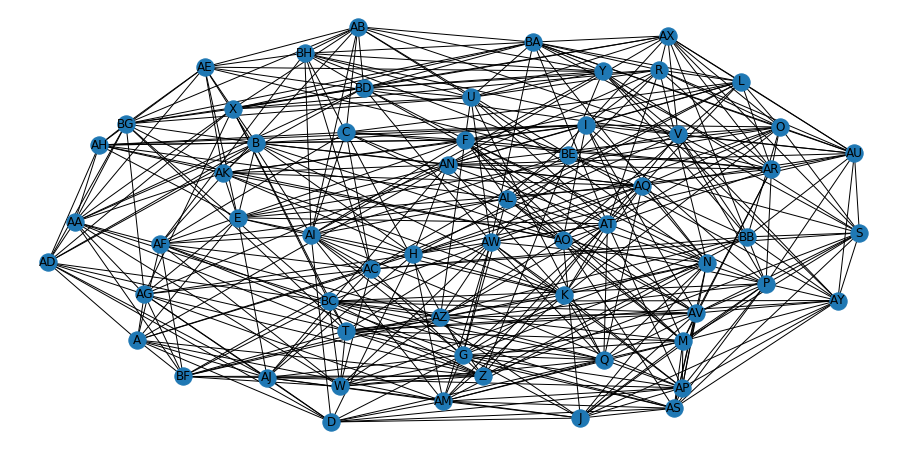

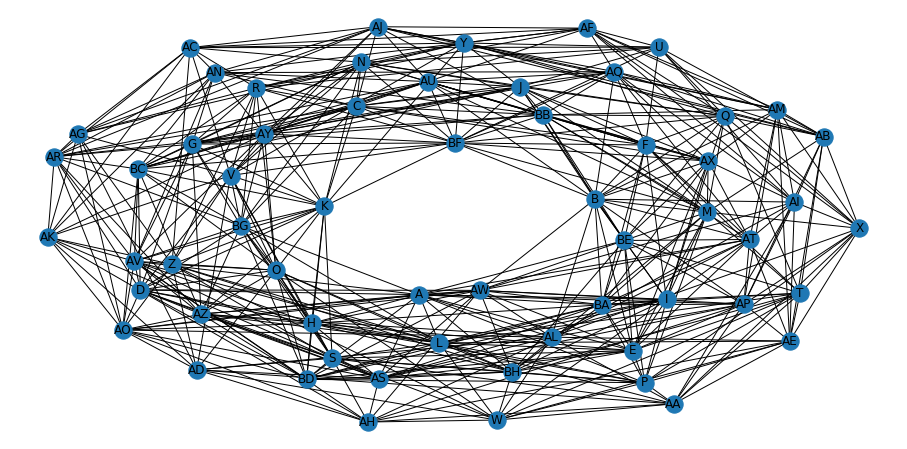

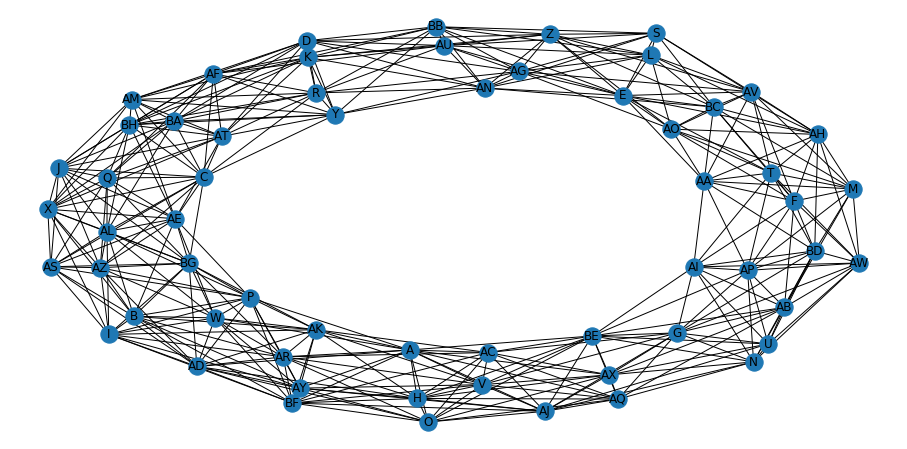

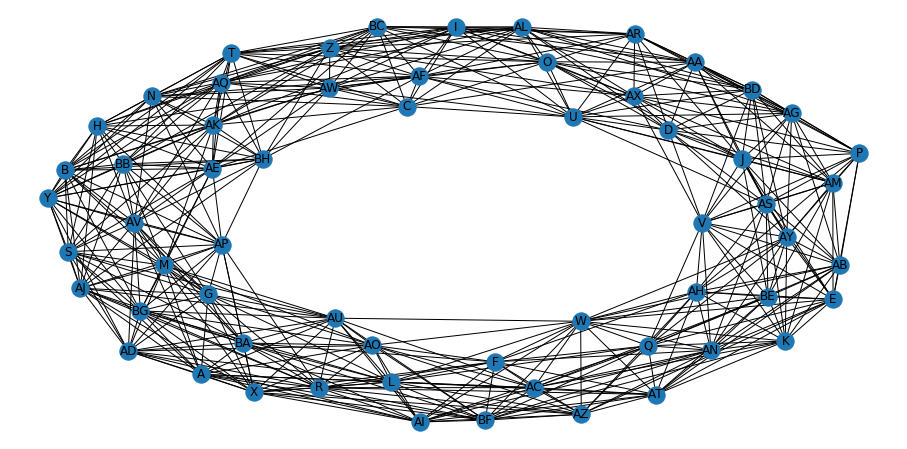

In [8]:
seeds = [np.pi, np.e, 2 ** .5, 3 ** .5]

for s in seeds:
    II = puzzle_from_seed_ii(s, 60)
    G = generate_graph_ii(II)

    fig, ax = plt.subplots(figsize=(16, 8))
    pos = nx.nx_agraph.graphviz_layout(G, prog='neato')
    draw_graph(G, pos, ax=ax)

# Triangle Version Helper Functions

In [2]:
import numpy as np
from collections import Counter
from itertools import chain, starmap, product
from operator import add
import pandas as pd

def generate_graph(puzzle):
    G = nx.Graph()
    #node_list = list(map(name_node, range(1, len(puzzle)+1)))
    # create nodes
    G.add_nodes_from(puzzle.keys())
    
    d = dzip(puzzle.keys(), map(lambda i: dict(Counter(i)), puzzle.values()))
    for b, data in pd.DataFrame(d).T.iteritems():
        nodes = data.iloc[np.where(~data.isna())].index.to_list()
        edges = [edge for edge in product(nodes, nodes) if edge[0] < edge[1]]
        weights = [data.iloc[np.where(data.index.isin((a, b)))].sum() for a, b in edges]
        G.add_edges_from(edges, weights=sum(weights))
        #print(nodes, weights, data)

    return G

def puzzle_from_seed(seed, n):
    group = lambda l, n: (tuple(l[j:j+n]) for j in range(0, len(l), n))
    generate_colors = lambda i: int(1+(np.floor(i*seed)%n))
    colors = group(list(map(generate_colors, range(1, 3*n+1))), 3)
    cubes = map(name_node, range(1, n+1))
    return dzip(cubes, colors)

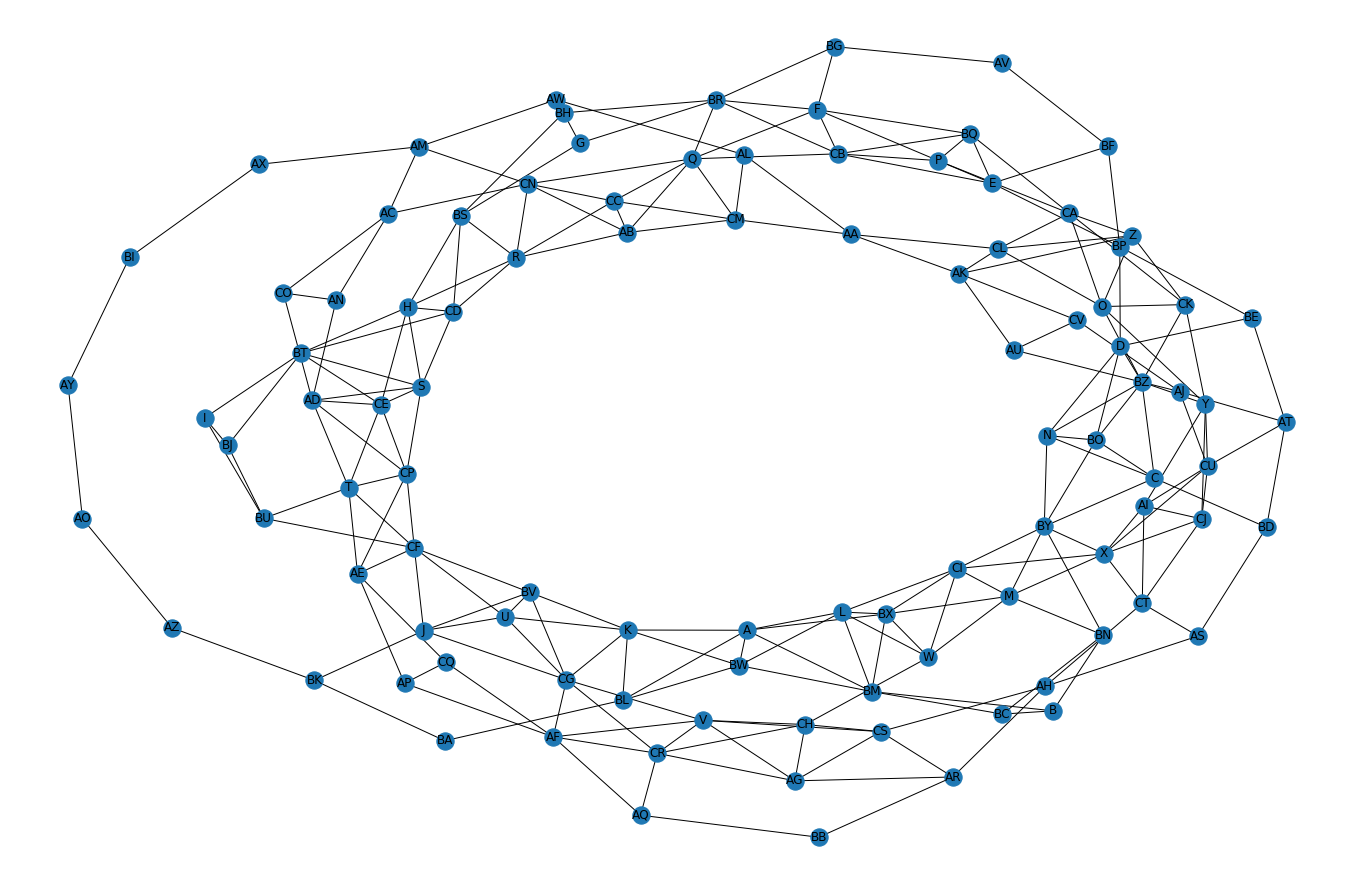

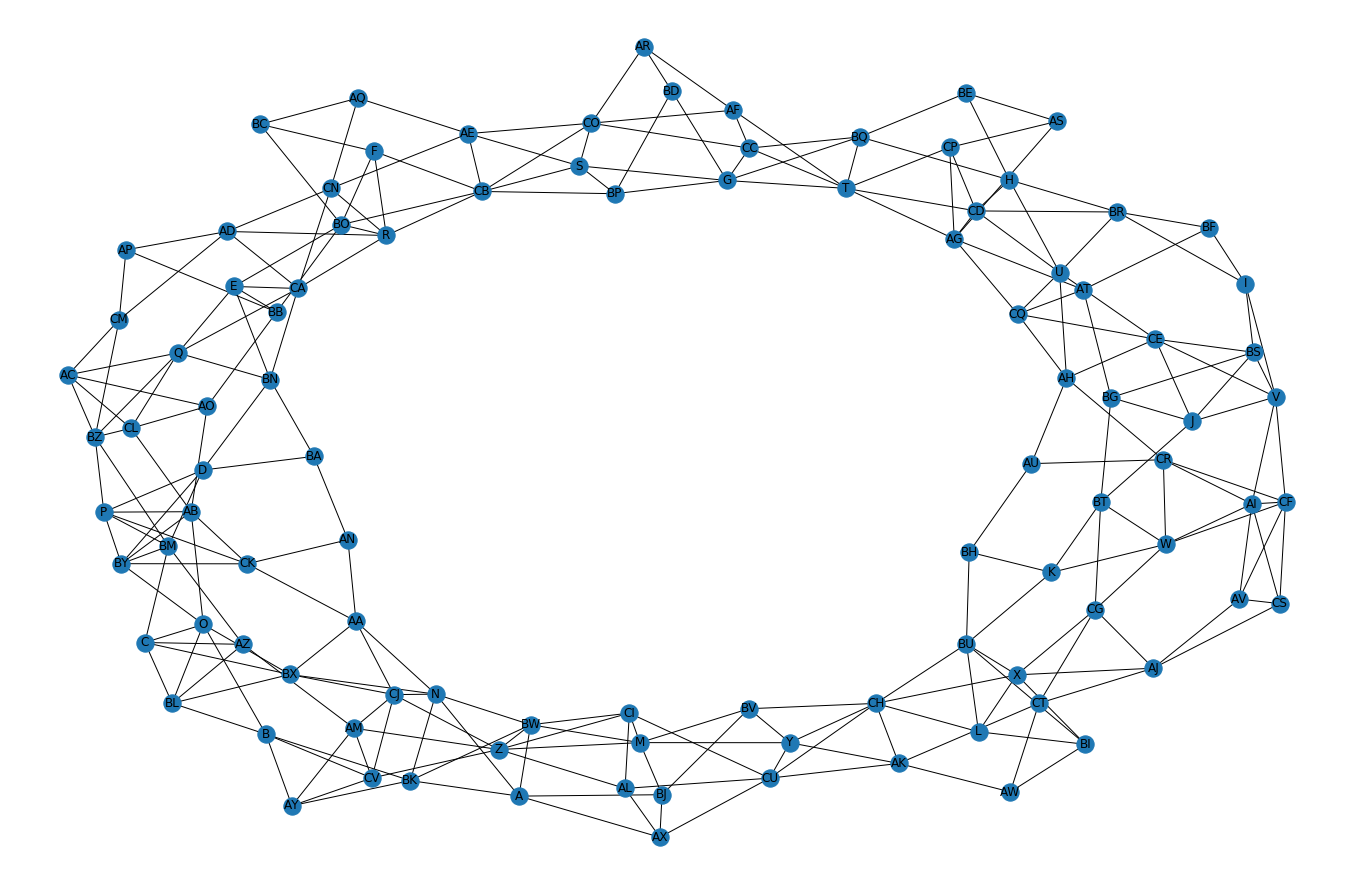

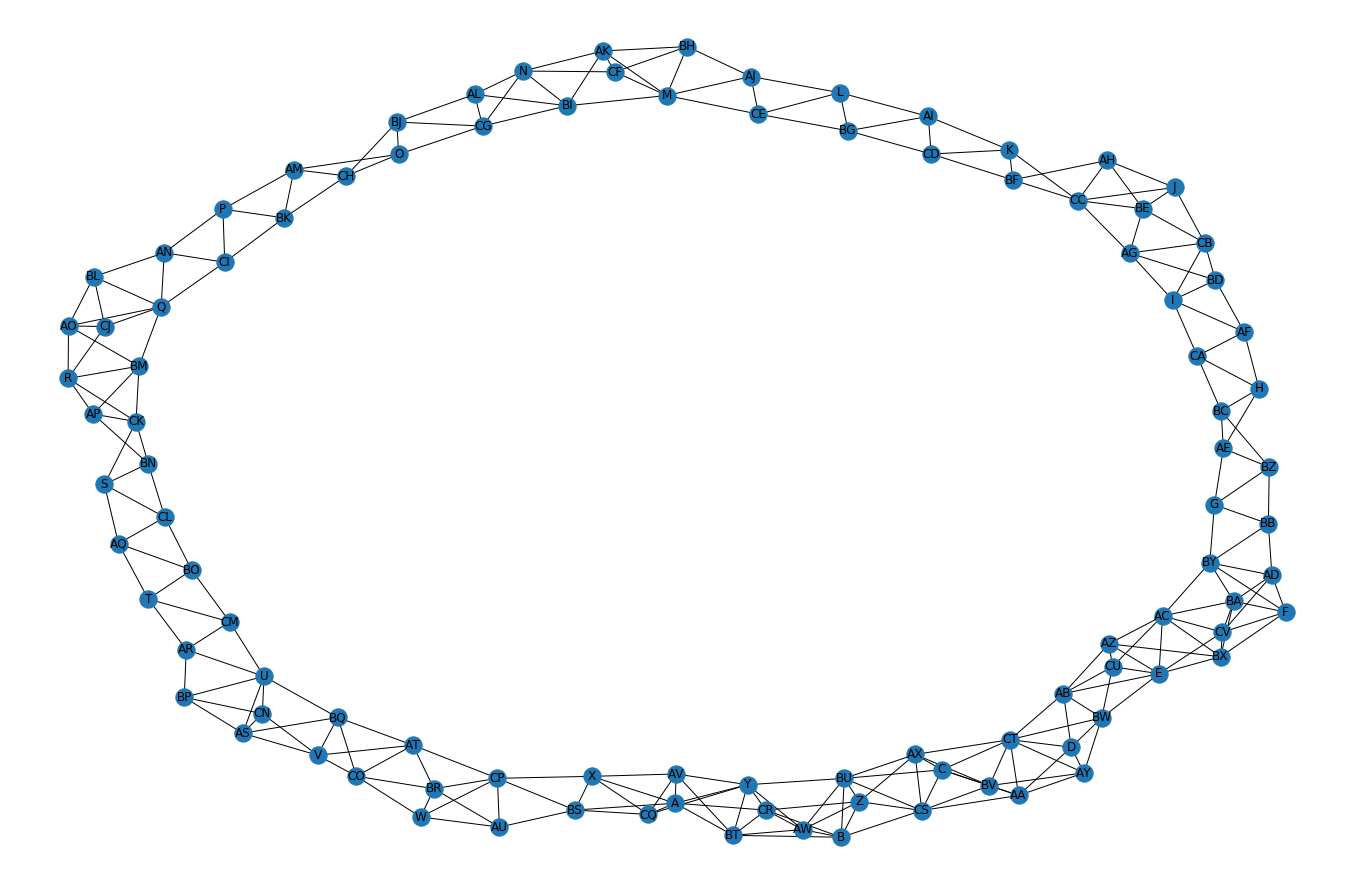

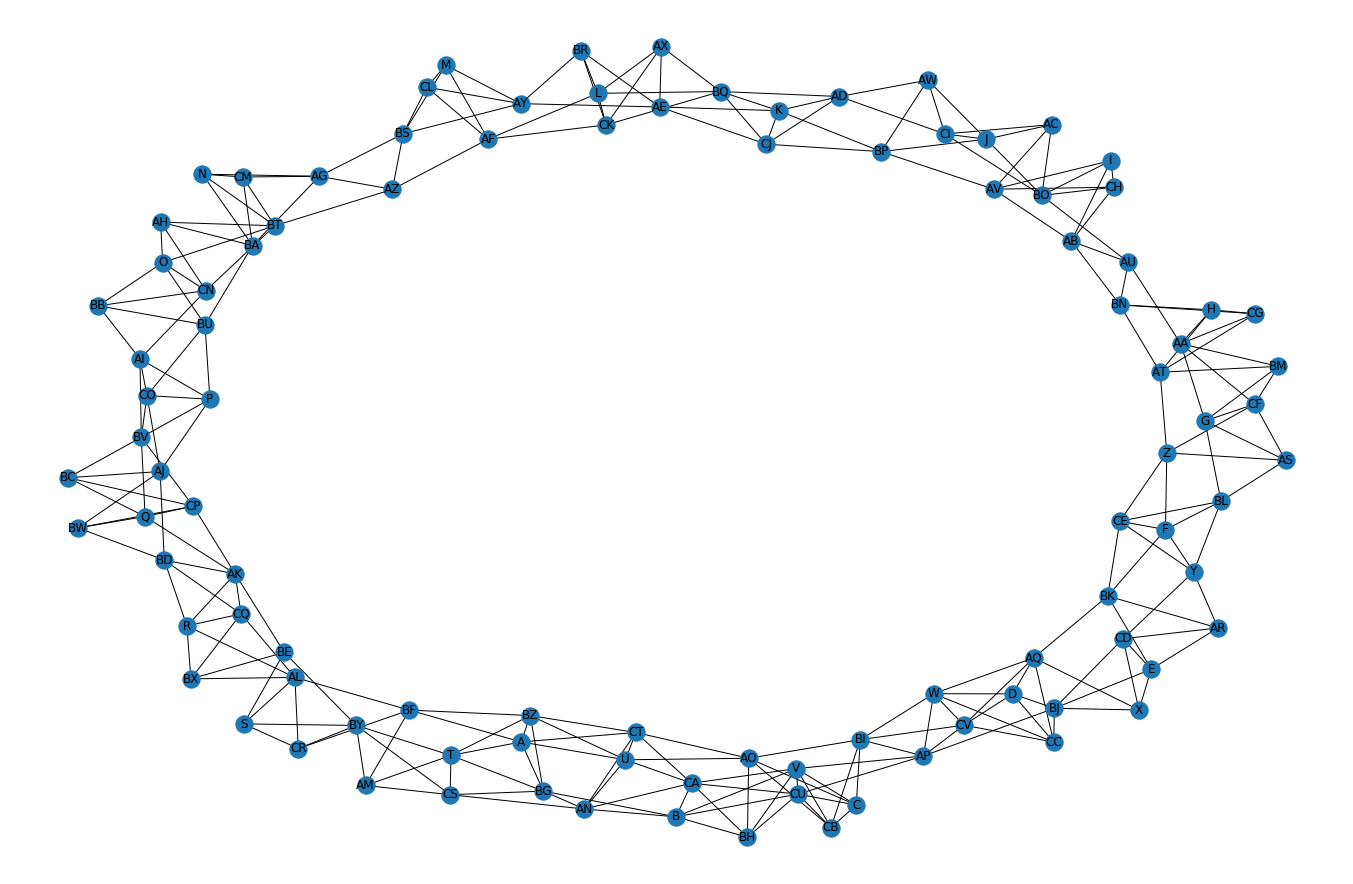

In [21]:
for s in seeds:
    TT = puzzle_from_seed(s, 100)
    G = generate_graph(TT)

    fig, ax = plt.subplots(figsize=(24, 16))
    pos = nx.nx_agraph.graphviz_layout(G, prog='neato')
    draw_graph(G, pos=pos, ax=ax)

# Solver

In [9]:
def puzzle_to_onehot(puzzle):
    one_hots = map(lambda i: dzip(i, [1]*3), puzzle.values())
    return pd.DataFrame(dzip(puzzle.keys(), one_hots))

def complete_solution(puzzle):
    return all(puzzle_to_onehot(puzzle).T.sum() == 3)

puzzles = [puzzle_from_seed(seed, 100) for seed in seeds]
list(filter(itemgetter(1), zip(seeds, map(complete_solution, puzzles))))

[]

In [10]:
#draw_graph(G, pos)
# 
#comp = community.girvan_newman(G, most_valuable_edge=lightest_edge)
#
#for i in takewhile(lambda A: len(A) < 25, comp)#len(list(chain(*A))), comp):
#    _, ax = plt.subplots()
#    for g in [G.subgraph(p) for p in i]:
#        draw_graph(g, pos, ax=ax)

**Constraints:**

1. Color # is incrementing
2. No Duplicates Colors in a single cube
3. 4 of the same color guarantees a collision
    * All colors must be used (no hiding colors)
    
**Algorithm:**   

1. Count colors
2. If color occurs 4 times, then the minimum obstacle is 4
3. A size 4 obstacle can be found by getting all the cubes with the color that occured 4 times

In [11]:
onehots = dzip(seeds, [puzzle_to_onehot(i) for i in puzzles])
for seed, v in onehots.items():
    counts = v.sum(axis=1)
    collision_color = counts.iloc[np.where(counts == 4)].index[0]
    color_vector = v.iloc[np.where(v.index == collision_color)]
    obstacle = color_vector.dropna(axis=1).columns.to_list()
    print(f'Seed {seed}: {obstacle}')

Seed 3.141592653589793: ['A', 'K', 'BL', 'BW']
Seed 2.718281828459045: ['A', 'N', 'BK', 'BW']
Seed 1.4142135623730951: ['A', 'X', 'BS', 'CQ']
Seed 1.7320508075688772: ['A', 'T', 'BG', 'BZ']


In [12]:
for seed, v in onehots.items():
    counts = v.sum(axis=1)
    display(counts.describe())

count    100.000000
mean       3.000000
std        0.852803
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
dtype: float64

count    100.000000
mean       3.000000
std        0.666667
min        2.000000
25%        3.000000
50%        3.000000
75%        3.000000
max        4.000000
dtype: float64

count    100.000000
mean       3.000000
std        0.512471
min        2.000000
25%        3.000000
50%        3.000000
75%        3.000000
max        4.000000
dtype: float64

count    100.000000
mean       3.000000
std        0.765414
min        2.000000
25%        2.000000
50%        3.000000
75%        3.250000
max        5.000000
dtype: float64

1. Always Stackable
2. DiGraph$_i$.rev() == DiGraph$_j$ for $i, j \in V$
3. The donut will be conquered and it will be conquered clockwise 
4. 4 of the same color guarantees a collision

In [42]:
Counter(map(frozenset, map(set, sorted(puzzle_from_seed(np.pi, 100).values(), key=np.mean))))

Counter({frozenset({1, 4, 7}): 1,
         frozenset({2, 5, 8}): 1,
         frozenset({3, 6, 9}): 1,
         frozenset({4, 7, 10}): 1,
         frozenset({5, 8, 11}): 1,
         frozenset({5, 8, 12}): 1,
         frozenset({7, 10, 13}): 1,
         frozenset({7, 10, 14}): 1,
         frozenset({8, 12, 15}): 1,
         frozenset({9, 12, 15}): 1,
         frozenset({10, 14, 17}): 1,
         frozenset({11, 14, 17}): 1,
         frozenset({13, 16, 19}): 2,
         frozenset({14, 17, 20}): 1,
         frozenset({15, 18, 21}): 1,
         frozenset({16, 19, 23}): 1,
         frozenset({17, 20, 23}): 1,
         frozenset({18, 21, 24}): 1,
         frozenset({18, 21, 25}): 1,
         frozenset({20, 23, 26}): 1,
         frozenset({20, 24, 27}): 1,
         frozenset({22, 25, 28}): 1,
         frozenset({22, 26, 29}): 1,
         frozenset({24, 27, 30}): 2,
         frozenset({26, 29, 32}): 2,
         frozenset({27, 30, 34}): 1,
         frozenset({28, 31, 34}): 1,
         frozenset({

In [9]:
color_counts = lambda puzzle: Counter(chain(*puzzle.values()))
puzzle = puzzle_from_seed(np.pi, 100)
color_counts(puzzle)

Counter({4: 4,
         7: 4,
         10: 4,
         13: 3,
         16: 3,
         19: 3,
         22: 2,
         26: 4,
         29: 4,
         32: 4,
         35: 3,
         38: 3,
         41: 3,
         44: 2,
         48: 4,
         51: 4,
         54: 4,
         57: 3,
         60: 3,
         63: 3,
         66: 2,
         70: 4,
         73: 4,
         76: 4,
         79: 3,
         82: 3,
         85: 3,
         88: 2,
         92: 4,
         95: 4,
         98: 4,
         1: 3,
         14: 4,
         17: 4,
         20: 4,
         23: 3,
         36: 4,
         39: 4,
         42: 4,
         45: 3,
         58: 4,
         61: 4,
         64: 4,
         67: 3,
         80: 4,
         83: 4,
         86: 4,
         89: 3,
         2: 4,
         5: 4,
         8: 4,
         11: 2,
         24: 4,
         27: 4,
         30: 4,
         33: 2,
         46: 3,
         49: 3,
         52: 3,
         55: 3,
         68: 3,
         71: 3,
         74: 3

In [26]:
data = pd.DataFrame(puzzle).apply(lambda i: (i[0], i[1], i[2]), axis=0)

In [35]:
np.where(4 in data)

(array([], dtype=int64),)

In [40]:
data.iloc[np.where()]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [43]:
data.loc['A']

'CV'

In [44]:
display(data.loc['A'])
display(data.loc['K'])
display(data.loc['BL'])
display(data.loc['BW'])

(4, 7, 10)

(98, 1, 4)

(97, 1, 4)

(1, 4, 7)